In [45]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

labels = ["NoEvents", "Attack", "Natural"]

X = pd.read_csv("Data/data%d.csv"%1) #read file

X = X.replace(np.inf, np.finfo(np.float32).max) #replacing 'inf' with its equivalent in float32 datatype

#preparing the label converter
le = preprocessing.LabelEncoder()
le.fit(labels)

#assigning the training data and the labels into variables
y = le.transform(X['marker'])
X = X.drop(columns='marker')

features = list(X.columns)

clf = RandomForestClassifier(n_estimators=100, max_features='log2')

X=X.values

In [46]:
from lime.lime_tabular import LimeTabularExplainer
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

clf.fit(X_train,y_train)

explainer = LimeTabularExplainer(X_train, training_labels = y_train, feature_names = features, class_names = labels)

In [53]:
Xall = []
for i in range(2,16):
    Xall.append(pd.read_csv("Data/data%d.csv"%i))

Xall = pd.concat(Xall)
Xall = Xall.replace(np.inf, np.finfo(np.float32).max) #replacing 'inf' with its equivalent in float32 datatype

#assigning the training data and the labels into variables
yall = le.transform(Xall['marker'])
Xall = Xall.drop(columns='marker')

X_test = np.concatenate((X_test, Xall.values), axis=0)
y_test = np.concatenate((y_test, yall))
print(y_test.size)

faulty = (y_test != clf.predict(X_test)) & (y_test == 0)
X_test = X_test[faulty]
y_test = y_test[faulty]
y_test.size

73411


6801

In [55]:
idx = 3

# print('Event id: %d' % idx)
# print('Predicted class =', labels[clf.predict(X_test[idx].reshape(1, -1))[0]])
# print('True class: %s' % labels[y_test[idx]])

lst = []
for idx in range(0, 100):
    exp = explainer.explain_instance(X_test[idx], clf.predict_proba, num_features=5, labels=[0, 1, 2])
    lst.append(exp.as_list())


In [63]:
lst = np.array(lst)
lst.shape
lst = lst[:,:,0]

(100, 5, 2)

In [138]:
dall = []
for j in range(0,5):
    k = []
    for i in range(0,100):
        k.append(sum(lst[:,j] == lst[i,j]))
    k = np.array(k)    
    arg = k.argsort()
    feat = lst[0:100]
    test = feat[arg, 0]
    d = np.column_stack((test, k[arg]))
    d = np.unique(d, axis=0)
    dall.append(d[d[:,1].astype('float64').argsort()[::-1]])

dall    

[array([['R3-PA4:IH > 101.85', '36'],
        ['R3-PM7:V > 130562.79', '17'],
        ['R2-PA1:VH <= -101.35', '6'],
        ['R3-PA4:IH <= -65.01', '5'],
        ['R2-PA4:IH > 101.05', '4'],
        ['R3-PM2:V > 130431.15', '3'],
        ['R1-PM5:I > 467.02', '3'],
        ['R3-PA10:IH > 101.90', '3'],
        ['R4-PA:ZH > 0.06', '2'],
        ['R4-PA6:IH > 75.13', '2'],
        ['R4-PA10:IH > 66.97', '2'],
        ['R4-PM10:I > 464.21', '2'],
        ['R3-PA3:VH <= -74.72', '2'],
        ['R2-PA3:VH <= -74.74', '2'],
        ['R1-PM4:I > 463.09', '1'],
        ['R1-PA3:VH > 77.36', '1'],
        ['R1-PM5:I <= 326.81', '1'],
        ['R1-PA:Z <= 8.20', '1'],
        ['R4-PM5:I > 469.01', '1'],
        ['R1-PM7:V <= 130932.62', '1'],
        ['R4-PM2:V > 132161.55', '1'],
        ['R3-PA5:IH <= -75.04', '1'],
        ['R3-PM2:V <= 128425.29', '1'],
        ['R4-PM2:V <= 130957.97', '1'],
        ['-65.01 < R3-PA4:IH <= 31.39', '1']], dtype='<U33'),
 array([['R3-PM7:V > 130562.79', '17'

In [31]:
import eli5
from eli5.sklearn import PermutationImportance
from eli5.ipython import show_weights
perm = PermutationImportance(clf).fit(X_test, y_test)
show_weights(perm, target_names = labels, feature_names = features, top = 10, show = ['feature_importances', 'targets', 'method', 'description'] , include_styles = False)

Weight,Feature
0 ± 0.0000,R2-PM6:I
0 ± 0.0000,R2-PM5:I
0 ± 0.0000,R2-PA3:VH
0 ± 0.0000,R2-PM9:V
0 ± 0.0000,R2-PA7:VH
0 ± 0.0000,R2-PM7:V
0 ± 0.0000,R2-PA8:VH
0 ± 0.0000,R2-PM8:V
0 ± 0.0000,R2-PA9:VH
0 ± 0.0000,snort_log4


In [25]:
from treeinterpreter import treeinterpreter as ti

instance = X_test[idx].reshape(1, -1)

prediction, bias, contributions = ti.predict(clf, instance)
print("Prediction", prediction)
print("Bias (trainset prior)", bias)
print("Feature contributions:")

for c, feature in zip(contributions[0], 
                             features):
    print(feature, c)

Prediction [[0.97 0.03 0.  ]]
Bias (trainset prior) [[0.77889851 0.18643174 0.03466975]]
Feature contributions:
R1-PA1:VH [-0.00626519  0.00808577 -0.00182058]
R1-PM1:V [ 0.01597154 -0.01597154  0.        ]
R1-PA2:VH [-0.00464311  0.00553816 -0.00089505]
R1-PM2:V [ 1.30064121e-02 -1.29245277e-02 -8.18843805e-05]
R1-PA3:VH [ 0.00223273 -0.00259053  0.0003578 ]
R1-PM3:V [ 0.00385603 -0.00296872 -0.00088731]
R1-PA4:IH [-0.00760093  0.00861705 -0.00101612]
R1-PM4:I [ 1.21436750e-02 -1.21072974e-02 -3.63775386e-05]
R1-PA5:IH [ 0.00411485 -0.00439385  0.00027899]
R1-PM5:I [ 0.00591601 -0.00560306 -0.00031296]
R1-PA6:IH [-0.00412015  0.00467144 -0.00055129]
R1-PM6:I [ 0.0018025 -0.0018025  0.       ]
R1-PA7:VH [-0.00721637  0.01019945 -0.00298308]
R1-PM7:V [ 0.00628519 -0.00628519  0.        ]
R1-PA8:VH [0. 0. 0.]
R1-PM8:V [0. 0. 0.]
R1-PA9:VH [0. 0. 0.]
R1-PM9:V [0. 0. 0.]
R1-PA10:IH [-0.00358375  0.00489702 -0.00131326]
R1-PM10:I [ 0.00557695 -0.00534457 -0.00023238]
R1-PA11:IH [ 0.00212378

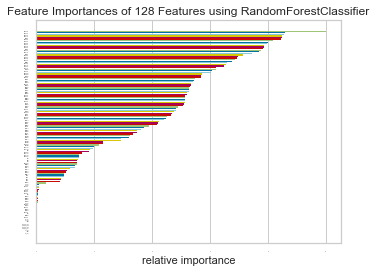

In [9]:
from yellowbrick.model_selection.importances import feature_importances
from matplotlib import pyplot as plt
clf.fit(X,y)

f2, ax2 = plt.subplots()
feature_importances(clf, X, y, ax2, labels = features, show=False)
ax2.tick_params(axis='both', which='major', labelsize=1)
ax2.tick_params(axis='both', which='minor', labelsize=1)